In [642]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import pickle as pk

In [643]:
df = pd.read_csv('./COEBiddingResultsPrices.csv', parse_dates=['month'])

In [644]:
df.head()

,month,bidding_no,vehicle_class,quota,bids_success,bids_received,premium
0,2010-01-01,1,Category A,1152,1145,1342,18502
1,2010-01-01,1,Category B,687,679,883,19190
2,2010-01-01,1,Category C,173,173,265,19001
3,2010-01-01,1,Category D,373,365,509,889
4,2010-01-01,1,Category E,586,567,1011,19889


In [645]:
# extract all vehicle classes for individual model training
vehicle_class = df.vehicle_class.unique().tolist()

# Treat all vehicle classes as one to quickly find the optimal PCA components

In [646]:
# sort by month and bidding_no
df = df.sort_values(['month', 'bidding_no'])

In [647]:
# clean up numerical cols
num_cols = ['quota', 'bids_received', 'bids_success', 'premium']
for col in num_cols:
    df[col] = df[col].astype(str).str.replace(r'[^\d.]', '', regex=True).astype(float)

In [648]:
# feature engineerings to include lags and moving average, to predict based on quota, bids_received(t-1), bids_success(t-1), premium(t-1)
# and their moving averages
def create_features(df, lags=[1], ma_windows=[3], mode='training'):
    df = df.copy()
    for col in ['bids_received', 'bids_success', 'premium']:
        for lag in lags:
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    for col in ['quota','bids_received_lag_1', 'bids_success_lag_1', 'premium_lag_1']:
        for window in ma_windows:
            df[f'{col}_ma{window}'] = df[col].rolling(window).mean()
    if mode == 'training':
        return df.dropna()
    else:
        return df
    

df = create_features(df)

In [649]:
df.head()

,month,bidding_no,vehicle_class,quota,bids_success,bids_received,premium,bids_received_lag_1,bids_success_lag_1,premium_lag_1,quota_ma3,bids_received_lag_1_ma3,bids_success_lag_1_ma3,premium_lag_1_ma3
3,2010-01-01,1,Category D,373.0,365.0,509.0,889.0,265.0,173.0,19001.0,411.000000,830.000000,665.666667,18897.666667
4,2010-01-01,1,Category E,586.0,567.0,1011.0,19889.0,509.0,365.0,889.0,377.333333,552.333333,405.666667,13026.666667
5,2010-01-01,2,Category A,1151.0,1149.0,1673.0,20501.0,1011.0,567.0,19889.0,703.333333,595.000000,368.333333,13259.666667
6,2010-01-01,2,Category B,717.0,717.0,1105.0,22400.0,1673.0,1149.0,20501.0,818.000000,1064.333333,693.666667,13759.666667
7,2010-01-01,2,Category C,181.0,173.0,280.0,20090.0,1105.0,717.0,22400.0,683.000000,1263.000000,811.000000,20930.000000


In [650]:
# prepare X and y
excluded_cols = ['month', 'bidding_no', 'vehicle_class', 'premium', 'bids_received', 'bids_success']
X = df[[col for col in df.columns if col not in excluded_cols]].copy()
y = df['premium'].copy()

In [651]:
# scale X and y
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1,1)).flatten()

In [652]:

# Fit PCA with max components
pca = PCA()
pca.fit(X_scaled)

PCA()

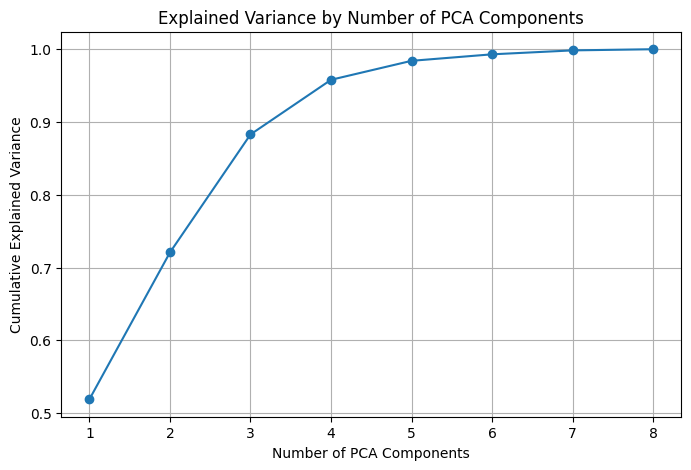

In [653]:
# Calculate cumulative explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Plot cumulative variance vs number of components
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of PCA Components')
plt.grid(True)
plt.show()


In [654]:
# Find number of components to reach threshold (e.g. 95%)
variance_threshold = 0.95
optimal_components = (cumulative_variance >= variance_threshold).argmax() + 1
print(f"Number of components to retain {variance_threshold*100}% variance: {optimal_components}")

Number of components to retain 95.0% variance: 4


# Traing model for each individual vehicle class

In [655]:
# look back half a year
time_steps = 6
# set optimal components = 4
pca_components = 4

In [662]:
# Cceate sequences for LSTM 
def create_sequences(X, y, time_steps=time_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])  # target is the next step after the sequence
    return np.array(X_seq), np.array(y_seq)

# train model
def train_model(df, v_class):
    print(f"Traing for: {v_class}")

    df = df[df.vehicle_class == v_class].copy()

    df = create_features(df)
    
    X = df[[col for col in df.columns if col not in excluded_cols]].copy()
    y = df['premium'].copy()

    # scale X and y
    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)
    pk.dump(scaler_X, open(f'./scalers/{v_class}_scaler_X.pkl', 'wb'))

    scaler_y = MinMaxScaler()
    # y_scaled = y.values.reshape(-1,1)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1,1)).flatten()
    pk.dump(scaler_y, open(f'./scalers/{v_class}_scaler_y.pkl', 'wb'))

    # fit PCA with optimal number of components
    # print (len(X.columns))
    pca = PCA(n_components=pca_components)  # pick number of components or variance threshold
    X_pca = pca.fit_transform(X_scaled)
    pk.dump(pca, open(f'./scalers/{v_class}_pca.pkl', 'wb'))
    # print(f"Explained variance ratio by PCA components: {pca.explained_variance_ratio_}")

    split_idx = int(len(X_pca) * 0.75) 

    X_train_raw, X_test_raw = X_pca[:split_idx], X_pca[split_idx:]
    y_train_raw, y_test_raw = y_scaled[:split_idx], y_scaled[split_idx:]

    X_train, y_train = create_sequences(X_train_raw, y_train_raw, time_steps)
    X_test, y_test = create_sequences(X_test_raw, y_test_raw, time_steps)

    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse')

    model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=0)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    print(f"MSE: {mse:.4f}")
    
    # save the model
    model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=[keras.metrics.MeanAbsoluteError()])
    model.save('./models/{}_lstm.h5'.format(v_class))

In [663]:
# reimport df and clean data
df = pd.read_csv('./COEBiddingResultsPrices.csv', parse_dates=['month'])

df = df.sort_values(['month', 'bidding_no'])

for col in num_cols:
    df[col] = df[col].astype(str).str.replace(r'[^\d.]', '', regex=True).astype(float)


for v_class in vehicle_class:
    train_model(df, v_class)

Traing for: Category A
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


MSE: 0.0347
Traing for: Category B
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


MSE: 0.0289
Traing for: Category C
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


MSE: 0.0112
Traing for: Category D
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


MSE: 0.0091
Traing for: Category E
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


MSE: 0.0130


# Make recommendation for each vehicle class via sensivity analysis
Assuming bids received and succeed as the mean of the past 10 transactions, and a stable price means that the next price is close to the previous price

In [664]:
# create a new row for prediction
def create_next_row(df, quota_value):
    # Copy df to avoid inplace edits
    df_ext = df.copy()
     
    # Initialize new row with NaNs
    df_ext.loc[len(df_ext)] = pd.Series()
    
    # Set Quota
    df_ext.loc[len(df_ext)-1, 'quota'] = quota_value

    # Recompute engineered features for the entire df_ext, especially the new row
    df_ext = create_features(df_ext, mode = 'testing')

    # print(df_ext.iloc[-1])
    
    return df_ext

In [665]:
def make_recommendation(df, model, v_class, scaler_X, scaler_y, pca):
    # Parameters
    time_steps = 10
    latest_price = df['premium'].iloc[-1]
    latest_quota = df['quota'].iloc[-1]

    # Define quota range to test (e.g., ±20% around latest quota)
    quota_current = df['quota'].iloc[-1]
    quota_range = np.linspace(quota_current * 0.75, quota_current * 1.25, 200)

    predicted_prices = []
    price_diffs = []

    for q in quota_range:
        df_new = create_next_row(df, q)

        df_new = df_new[[col for col in df_new.columns if col not in excluded_cols + ['index']]].copy()
        
        # Extract last time_steps rows (including the new row) for model input
        input_seq_df = df_new.tail(time_steps)
        
        # Scale and PCA transform
        scaled = scaler_X.transform(input_seq_df)
        pca_features = pca.transform(scaled)
        
        # Reshape for LSTM input: (1, time_steps, n_features)
        input_seq = np.expand_dims(pca_features, axis=0)
    
        
        # Predict next COE price
        pred_scaled = model.predict(input_seq)
        # pred_price = pred_scaled[0][0]
        pred_price = scaler_y.inverse_transform(pred_scaled)[0][0]
        
        predicted_prices.append(pred_price)
        price_diffs.append(abs(pred_price - latest_price))

    # Find optimal quota minimizing price deviation
    if price_diffs:
        min_idx = np.argmin(price_diffs)
        optimal_quota = quota_range[min_idx]
        optimal_price = predicted_prices[min_idx]
        
        print(f"Vehicle Class: {v_class}")
        print(f"\t Latest COE price: {latest_price:.2f}")
        print(f"\t Latest COE Quota: {latest_quota}")
        print(f"\t Recommended next quota: {optimal_quota:.0f} to stabilize predicted price at approx {optimal_price:.2f}")
    else:
        print("No valid quota candidate due to NaNs in features.")

In [666]:
import warnings
warnings.filterwarnings('ignore')

In [667]:
from tensorflow.keras.models import load_model
for v_class in vehicle_class:
    model = load_model('./models/{}_lstm.h5'.format(v_class))
    input_df = df[df.vehicle_class == v_class].reset_index().copy()
    scaler_X = pk.load(open(f'./scalers/{v_class}_scaler_X.pkl', 'rb'))
    scaler_y = pk.load(open(f'./scalers/{v_class}_scaler_y.pkl', 'rb'))
    pca = pk.load(open(f'./scalers/{v_class}_pca.pkl', 'rb'))
    make_recommendation(input_df, model, v_class, scaler_X, scaler_y, pca)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

Vehicle Class: Category D
	 Latest COE price: 9389.00
	 Latest COE Quota: 533.0
	 Recommended next quota: 666 to stabilize predicted price at approx 12886.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━